In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray

In [3]:
from mmctools.helper_functions import fit_power_law_alpha

In [4]:
from study import V27, unstable

# Estimate inflow from upstream plane
- velocity profile $= \bar{U}(t,z)$
- $\bar{U}$ is a 1-min rolling mean
- need offset in time from the x=-2.5D plane to the downstream wake planes

In [5]:
case = unstable(casedir='WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable',
                prefix='NREL_SHALER_DWMT_LES_190910',
                suffix='_Unstable',
                turbine=V27)

In [6]:
-case.upstreamD*V27.D

67.5

## Load data into wake object

In [7]:
xa = xarray.open_dataset(case.get_wake_datafile(case.upstreamD))
xa

Selected datafile: WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/NREL_SHALER_DWMT_LES_190910_uvw_-2.5D_Unstable.nc


<xarray.Dataset>
Dimensions:  (t: 875, x: 1, y: 66, z: 35)
Coordinates:
  * t        (t) float64 500.0 502.0 504.0 ... 2.244e+03 2.246e+03 2.248e+03
  * x        (x) float64 -67.5
  * y        (y) float64 -181.8 -179.3 -176.8 -174.3 ... -24.89 -22.4 -19.91
  * z        (z) float64 1.25 3.75 6.25 8.75 11.25 ... 78.75 81.25 83.75 86.25
Data variables:
    U        (t, x, y, z) float64 ...
    V        (t, x, y, z) float64 ...
    W        (t, x, y, z) float64 ...

In [8]:
Ntimes = xa.dims['t']

In [9]:
t = xa.t.values
z = xa.z.values

In [10]:
xa.U

<xarray.DataArray 'U' (t: 875, x: 1, y: 66, z: 35)>
[2021250 values with dtype=float64]
Coordinates:
  * t        (t) float64 500.0 502.0 504.0 ... 2.244e+03 2.246e+03 2.248e+03
  * x        (x) float64 -67.5
  * y        (y) float64 -181.8 -179.3 -176.8 -174.3 ... -24.89 -22.4 -19.91
  * z        (z) float64 1.25 3.75 6.25 8.75 11.25 ... 78.75 81.25 83.75 86.25
Attributes:
    long_name:  streamwise wind component
    units:      m/s

## Estimate TI

In [11]:
khub = np.argmin(np.abs(xa.coords['z'] - case.turbine.zhub))
print(khub, xa.coords['z'][khub])

<xarray.DataArray 'z' ()>
array(12) <xarray.DataArray 'z' ()>
array(31.25)
Coordinates:
    z        float64 31.25


In [12]:
Uhub = xa.sel(dict(
    x=case.upstreamD*case.turbine.D,
    z=xa.coords['z'].values[khub]
)).to_dataframe()['U']

In [13]:
Ustd = Uhub.unstack().std().mean()
Ustd

0.7727263188525626

In [14]:
Ustd/case.Uref

0.11533228639590486

## Estimate profile

In [15]:
Uprofile_inst = xa.U.mean(dim=('x','y')) # average over x,y: U(t,z)

In [16]:
Uprofile_mean = Uprofile_inst.rolling(dim={'t':case.Navg}).mean()

In [17]:
Uprofile = Uprofile_inst.mean(dim='t') # average over t,x,y: U(z)

In [18]:
Uprofile_inst.shape, Uprofile_mean.shape, Uprofile.shape

((875, 35), (875, 35), (35,))

In [19]:
# profile envelope
Uprofile_min = Uprofile_inst.min(dim='t')
Uprofile_max = Uprofile_inst.max(dim='t')
Uprofile_std = Uprofile_inst.std(dim='t')

## Estimate simulated $\alpha$

In [20]:
alpha,R2 = fit_power_law_alpha(z,Uprofile,
                               zref=case.turbine.zhub,
                               Uref=case.Uref)

## Plot

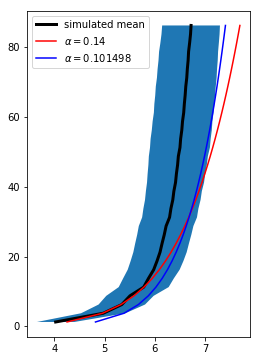

In [21]:
fig,ax = plt.subplots(figsize=(4,6))
ax.plot(Uprofile,z,'k',lw=3,label='simulated mean')
#ax.fill_betweenx(z, Uprofile_min, Uprofile_max)
ax.fill_betweenx(z, Uprofile-Uprofile_std, Uprofile+Uprofile_std)

U_powerlaw = case.Uref * (z/case.turbine.zhub)**case.alpha
ax.plot(U_powerlaw,z,'r',label=r'$\alpha = {:g}$'.format(case.alpha))

U_powerlaw = case.Uref * (z/case.turbine.zhub)**alpha
ax.plot(U_powerlaw,z,color='b',label=r'$\alpha = {:g}$'.format(alpha))

ax.legend()

## save data
Values/nans for *rolling mean* `U_mean` of upstream sampled inflow for `Noffset==7`, `Navg==60`, and `Ntimes==1663`:
```
tidx  U(x=-2.5D)      U(x=0)
---  ---------------  -----------
0     nan             ???
7     nan             U_mean(t=0)==nan
59    U_mean(t=59)    U_mean(t=52)==nan
66    U_mean(t=66)    U_mean(t=59)
1655  U_mean(t=1655)  U_mean(t=1648)
1662  U_mean(t=1662)  U_mean(t=1655)
```
Therefore,
- upstream U(t,z) for t $\in$ [`Navg`-1, -`Noffset`]
- inflow U(t,z) for t $\in$ [`Navg`+`Noffset`-1, -1]

In [22]:
# number of planes before inflow hits the rotor
Noffset = int(-case.upstreamD*V27.D / case.Uref)
Noffset

10

In [23]:
np.savez(os.path.join(case.casedir,'inflow.npz'), z=z, U=Uprofile_mean.values)